In [27]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
from celldreamer.eval.evaluate import compute_prdc
import scipy.sparse as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

In [28]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

## Step 1: Initialize data

In [29]:
dataset_config = {'dataset_path': DATA_DIR / 'processed' / 'tabula_muris.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['tissue'],
                    'conditioning_covariate': 'tissue',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
scaler = dataset.get_scaler()
n_cat = len(dataset.id2cov["tissue"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


learnt_autoencoder


## Step 2: Initialize encoder

In [30]:
encoder_config = {
    "x0_from_x_kwargs": {
        # "dims": [512, 256, 50],
        "dims": [500, 300, 200],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_tabula_muris_200/e0a066ae-8429-4010-aecf-a73e78e9d1ea/checkpoints/epoch_199.ckpt"
# state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_tabula_muris/60392a17-a375-4b36-8ccc-3a6b7aec5198/checkpoints/epoch_199.ckpt"

In [31]:
encoder_model = EncoderModel(in_dim=in_dim,
                              scaler=scaler, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2000, out_features=500, bias=True)
        (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=500, out_features=300, bias=True)
        (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=300, out_features=200, bias=True)
    )
  )
  (x_from_x0): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=200, out_features=300, bias=True)
        (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=300, out_features=500, bias=True)
        (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_runni

## Initialize FM model

In [32]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001
                        }

In [33]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_tabula_muris_200/000356d8-50f8-479d-9863-69e9e56498f2/checkpoints/last.ckpt")
# ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_tabula_muris/7547e32e-22be-458e-b1f9-89ae3bc960c4/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [ ]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["tissue"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Initializations

In [ ]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            scaler=scaler,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

**Check the data**

In [ ]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
sc.pp.subsample(adata_original, 0.5)
X = torch.tensor(adata_original.layers["X_counts"].todense())

In [36]:
unique_classes = np.unique(adata_original.obs.tissue, return_counts=True)
unique_classes = dict(zip(unique_classes[0], unique_classes[1]))
unique_classes

{'Bladder': 4509,
 'Fat': 3354,
 'Heart_and_Aorta': 4383,
 'Kidney': 10848,
 'Large_Intestine': 943,
 'Limb_Muscle': 14381,
 'Liver': 3623,
 'Lung': 12269,
 'Mammary_Gland': 6144,
 'Marrow': 20080,
 'Pancreas': 3143,
 'Skin': 2177,
 'Spleen': 17930,
 'Thymus': 4609,
 'Tongue': 10286,
 'Trachea': 4015}

**Collect checkpoints and run**

General conditional

In [ ]:
X_generated_list = []
classes_str = []
for _ in tqdm(range(100)):
    num_indices =1000
    index_range = len(X)
    
    # Generate random dummy indices without replacement
    indices = random.sample(range(index_range), num_indices)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_indices.obs.tissue)
    classes_str += classes
    classes = torch.tensor([dataset.id2cov["tissue"][c] for  c in classes]).cuda()

    log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()
    X_generated = generative_model.batched_sample(batch_size=100,
                                                repetitions=10,
                                                n_sample_steps=2, 
                                                covariate="tissue", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

    X_generated_list.append(X_generated.to("cpu"))

In [ ]:
X_generated_list = torch.cat(X_generated_list, dim=0)

In [ ]:
X_generated_list.shape

Single condition

In [ ]:
dataset.id2cov["tissue"]

In [ ]:
# # Pick condition 
# condition_name = "Marrow"
# condition_val = dataset.id2cov["tissue"][condition_name]
# adata_cond = adata_original[adata_original.obs.tissue==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]


# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="tissue", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [ ]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_list).cpu().numpy()))

In [ ]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

In [ ]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

In [ ]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color="size_factor")

In [ ]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

Merge and plot the generated and real data

In [ ]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated_list.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["classes"] = list(adata_original.obs.tissue)+list(classes_str)

In [ ]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated_list], dim=0).numpy(), 
                             obs=dataset_type)

In [ ]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


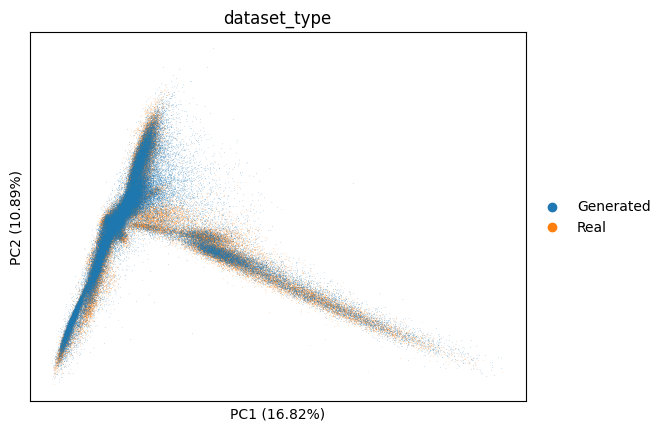

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

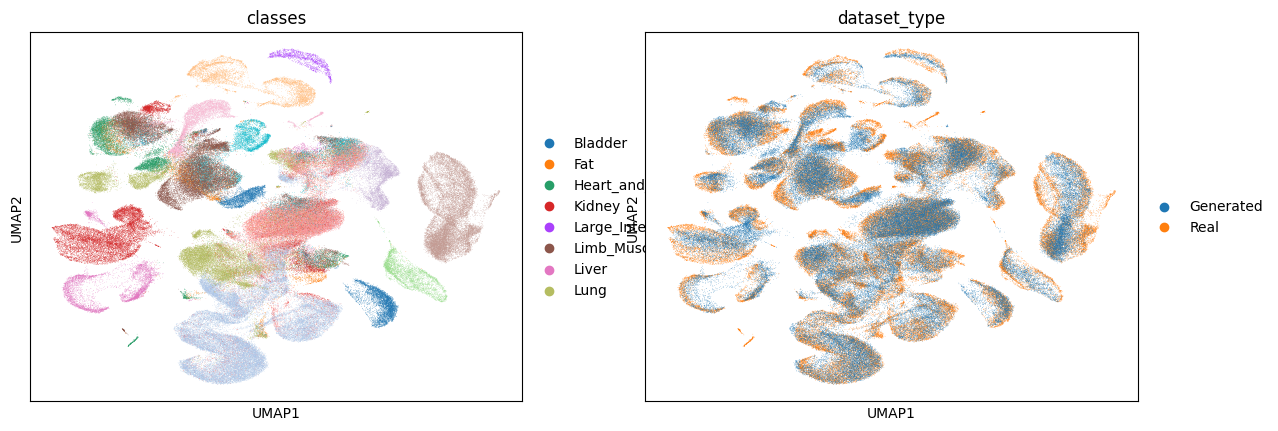

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


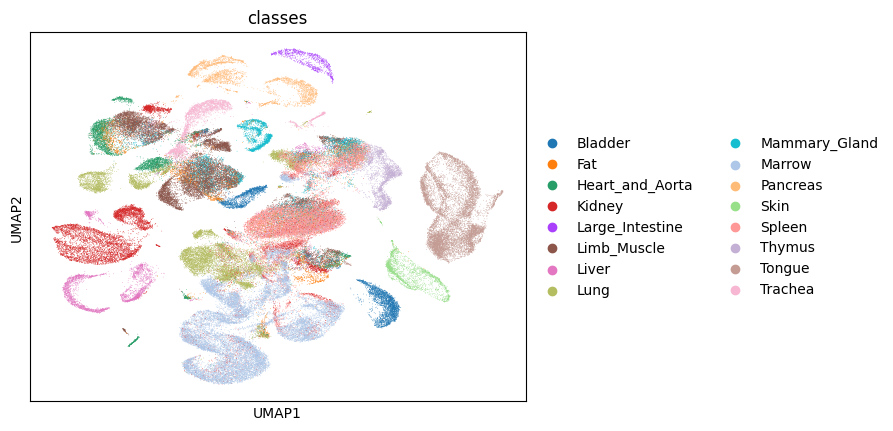

In [34]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["classes","dataset_type"])
sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color=["classes"])